# Navigation

---

In this notebook, I present my solution to Project 1 in [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. The Environment

The enviroment is prepared as instructed by https://github.com/udacity/deep-reinforcement-learning#dependencies. The solution is developed in Windows 11.

mujoco, as part of the OpenAI Gym dependence, failed to build. PyTorch v0.4 is replaced by 1.10.1, and intel-openmp v2020.0.133 is replaced by v2022.0.0, both due to availability from the default repo. The following is the list of requirement packages, which I got from the Peer Chat Channel.

```Python
tensorflow==1.7.1
Pillow>=4.2.1
matplotlib==3.1.1
numpy>=1.11.0
jupyter
pytest>=3.2.2
docopt
pyyaml
protobuf==3.5.2
grpcio==1.11.0
torch==1.10.1
pandas
scipy
ipykernel
certifi==2019.9.11
#libblas==3.8.0
#libcblas==3.8.0
#liblapack==3.8.0
pip==19.3.1
pycparser==2.19
setuptools==41.6.0
wheel==0.33.6
absl-py==0.8.1
astor==0.8.0
atomicwrites==1.3.0
attrs==19.3.0
backcall==0.1.0
bleach==1.5.0
cloudpickle==1.2.2
colorama==0.4.1
cycler==0.10.0
decorator==4.4.1
defusedxml==0.6.0
docopt==0.6.2
entrypoints==0.3
future==0.18.2
gast==0.3.2
grpcio==1.11.0
html5lib==0.9999999
importlib-metadata==0.23
ipykernel==5.1.3
ipython==7.9.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.15.1
jinja2==2.10.3
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==5.3.4
jupyter-console==6.0.0
jupyter-core==4.6.1
kiwisolver==1.1.0
markdown==3.1.1
markupsafe==1.1.1
matplotlib==3.1.1
mistune==0.8.4
more-itertools==7.2.0
nbconvert==5.6.1
nbformat==4.4.0
notebook==6.0.2
opencv-python==4.1.2.30
packaging==19.2
pandas==0.25.3
pandocfilters==1.4.2
parso==0.5.1
pickleshare==0.7.5
pillow==6.2.1
pluggy==0.13.0
prometheus-client==0.7.1
prompt-toolkit==2.0.10
protobuf==3.5.2
py==1.8.0
pyglet==1.3.2
pygments==2.4.2
pyparsing==2.4.5
pyrsistent==0.15.5
pytest==5.3.0
python-dateutil==2.8.1
pytz==2019.3
pywinpty==0.5.5
pyyaml==5.1.2
pyzmq==18.1.1
qtconsole==4.6.0
scipy==1.3.2
send2trash==1.5.0
six==1.13.0
tensorboard==1.7.0
tensorflow==1.7.1
termcolor==1.1.0
terminado==0.8.3
testpath==0.4.4
tornado==6.0.3
traitlets==4.3.3
unityagents==0.4.0
wcwidth==0.1.7
werkzeug==0.16.0
widgetsnbextension==3.5.1
zipp==0.6.0
cffi==1.13.2
#python==3.6.7
#pytorch==0.4.0
#vc==14.1
numpy==1.17.3
wincertstore==0.2
#vs2015_runtime==14.16.27012
#intel-openmp==2019.4
intel-openmp==2022.0.0
#mkl==2019.4
mkl==2019.0
```

We begin by importing some necessary packages. 

In [14]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Loading the Banana Navigation enviroment by pointing the path to the EXE file in Windows.

In [2]:
env = UnityEnvironment(file_name=r"./Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Setting the Environment **_brain_**.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.16895212 0.
 1.         0.         0.         0.20073597 1.         0.
 0.         0.         0.12865657 0.         1.         0.
 0.         0.14938059 1.         0.         0.         0.
 0.58185619 0.         1.         0.         0.         0.16089135
 0.         1.         0.         0.         0.31775284 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [25]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


In [38]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
i = 0

while True:
    action = agent.act(state).item()
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))

Score: -1.0


When finished, you can close the environment.

In [39]:
env.close()

### 4. Training!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)

def dqn(brain_name, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps).item()
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]   
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=16.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn(brain_name)

Episode 100	Average Score: 1.01
Episode 200	Average Score: 4.43
Episode 300	Average Score: 8.94
Episode 400	Average Score: 10.58
Episode 500	Average Score: 12.31
Episode 600	Average Score: 14.06
Episode 700	Average Score: 15.29
Episode 800	Average Score: 14.97
Episode 900	Average Score: 14.70
Episode 1000	Average Score: 15.62
Episode 1100	Average Score: 16.12
Episode 1200	Average Score: 15.09
Episode 1300	Average Score: 16.87
Episode 1400	Average Score: 16.44
Episode 1500	Average Score: 16.41
Episode 1600	Average Score: 15.97
Episode 1700	Average Score: 15.58
Episode 1800	Average Score: 14.82
Episode 1900	Average Score: 14.59
Episode 2000	Average Score: 15.24


NameError: name 'plt' is not defined

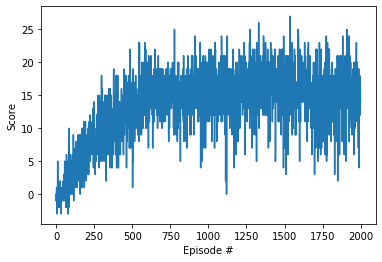

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. See trained Agent in action

In [12]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0

while True:
    action = agent.act(state).item()
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))

Score: 8.0


In [15]:
torch.save(agent.qnetwork_local.state_dict(), r'.\checkpoint.pth')